In [1]:
import numpy as np
from PIL import Image
from skimage.restoration import denoise_wavelet

import sys
sys.path.append('..')
import os
from glob import glob
import pandas as pd
from collections import OrderedDict

from prnu.prnu.functions import wiener_dft, zero_mean_total, wiener_adaptive
from params import runs_path, results_path

In [2]:
import matplotlib as mpl
mpl.use("pgf")
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
}
mpl.rcParams.update(pgf_with_rc_fonts)

In [108]:
import matplotlib.pyplot as plt
fontsize = 16
plt.rc('text', usetex=True)
plt.rc('font', family='sans',size=fontsize)
plt.rc('legend',fontsize=fontsize)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)
plt.rc('axes',labelsize=fontsize,titlesize=fontsize)
plt.rc('lines',linewidth=2)
%matplotlib inline

In [ ]:
# import seaborn as sns
# sns.set()
# cmap =sns.light_palette("Navy", as_cmap=True)


## Features

### Kirchner

In [ ]:
img_kirc_path = '/nas/home/nbonettini/projects/prnu-anonymization-detector/dataset/kirchner/Nikon_D200_0_14921.png'
img_kirc = np.array(Image.open(img_kirc_path)) / 255.
img_kirc_den_wv = denoise_wavelet(img_kirc, multichannel=True)
img_kirc_noise_wv = img_kirc - img_kirc_den_wv
# clim_wv = [np.min(img_kirc_noise_wv), np.max(img_kirc_noise_wv)]
img_kirc_noise_wv_fft = np.abs((np.fft.fft2(img_kirc_noise_wv,(224*2,224*2),axes=[0,1])))[:224,:224]

W = np.zeros_like(img_kirc_noise_wv_fft)
for c in range(img_kirc_noise_wv_fft.ndim):
    W_c = zero_mean_total(img_kirc_noise_wv_fft[:,:,c])
    W_c_std = W_c.std(ddof=1)
    W[:,:,c] = wiener_adaptive(W_c, (W_c_std**2)*0.77, window_size_list=[3]).astype(np.float32)
    

In [ ]:
plt.figure(figsize=(4,4));

plt.imshow(img_kirc);
plt.axis('off')
plt.axis('image')
plt.grid(False)

plt.savefig('figures/feature_raw.pdf',bbox_inches='tight')

In [ ]:
plt.figure(figsize=(4,4));
# plt.subplot(2, 2, 2);
plt.imshow(img_kirc_noise_wv.mean(axis=2));
# plt.colorbar(shrink=0.65);
plt.axis('off')
plt.axis('image')
plt.grid(False)
plt.tight_layout()

plt.savefig('figures/feature_wv.pdf',bbox_inches='tight')

In [ ]:
plt.figure(figsize=(4,4));
# plt.subplot(2, 2, 3);
plt.imshow(img_kirc_noise_wv_fft.mean(axis=2));
# plt.colorbar(shrink=0.82)
plt.axis('off')
plt.axis('image')
plt.grid(False)

plt.savefig('figures/feature_wv_fft.pdf',bbox_inches='tight')

In [ ]:
plt.figure(figsize=(4,4));
# plt.subplot(2, 2, 4);
plt.imshow(W.mean(axis=2));
# plt.colorbar(shrink=0.81)
plt.axis('off')
plt.axis('image')
plt.grid(False)

plt.savefig('figures/feature_wv_fft_wiener.pdf',bbox_inches='tight')

### Mandelli

In [148]:
img_kirc_path = '/nas/home/nbonettini/projects/prnu-anonymization-detector/dataset/mandelli/Nikon_D200_0_14921.png'
img_kirc = np.array(Image.open(img_kirc_path)) / 255.
img_kirc_den_wv = denoise_wavelet(img_kirc, multichannel=True)
img_kirc_noise_wv = img_kirc - img_kirc_den_wv
# clim_wv = [np.min(img_kirc_noise_wv), np.max(img_kirc_noise_wv)]
img_kirc_noise_wv_fft = np.abs((np.fft.fft2(img_kirc_noise_wv,(224*2,224*2),axes=[0,1])))[:224,:224]

W = np.zeros_like(img_kirc_noise_wv_fft)
for c in range(img_kirc_noise_wv_fft.ndim):
    W_c = zero_mean_total(img_kirc_noise_wv_fft[:,:,c])
    W_c_std = W_c.std(ddof=1)
    W[:,:,c] = wiener_adaptive(W_c, (W_c_std**2)*0.77, window_size_list=[3]).astype(np.float32)
    

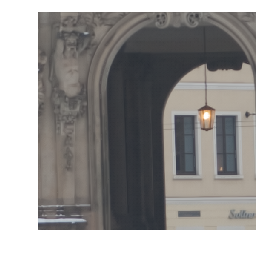

In [154]:
plt.figure(figsize=(4,4));

plt.imshow(img_kirc);
plt.axis('off')
plt.axis('image')
plt.grid(False)

plt.savefig('figures/feature_raw_mandelli.pdf',bbox_inches='tight')

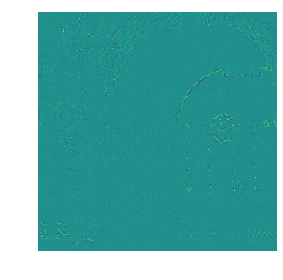

In [155]:
plt.figure(figsize=(4,4));
# plt.subplot(2, 2, 2);
plt.imshow(img_kirc_noise_wv.mean(axis=2));
# plt.colorbar(shrink=0.65);
plt.axis('off')
plt.axis('image')
plt.grid(False)
plt.tight_layout()

plt.savefig('figures/feature_wv_mandelli.pdf',bbox_inches='tight')

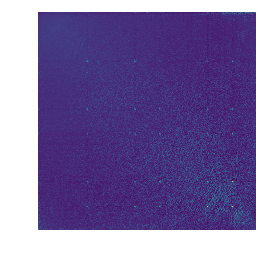

In [157]:
plt.figure(figsize=(4,4));
# plt.subplot(2, 2, 3);
plt.imshow(img_kirc_noise_wv_fft.mean(axis=2));
# plt.colorbar(shrink=0.82)
plt.axis('off')
plt.axis('image')
plt.grid(False)

plt.savefig('figures/feature_wv_fft_mandelli.pdf',bbox_inches='tight')

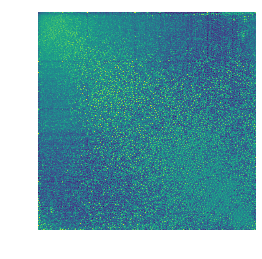

In [158]:
plt.figure(figsize=(4,4));
# plt.subplot(2, 2, 4);
plt.imshow(W.mean(axis=2));
# plt.colorbar(shrink=0.81)
plt.axis('off')
plt.axis('image')
plt.grid(False)

plt.savefig('figures/feature_wv_fft_wiener_mandelli.pdf',bbox_inches='tight')

## Cross dataset ROC

In [4]:
linestyles = ['-', '--', '-.', ':']

### Resnet complete feature over two testing dataset

In [122]:
# building translation dictionary
runs_name = [x.split('/')[-1] for x in glob(os.path.join(runs_path, 'ResNet_*_transform_wv_fft_wiener2*'))]
run_dict = {'_'.join(x.rsplit('_')[:-12]): x.rsplit('-')[-1] for x in runs_name}
run_dict = OrderedDict(run_dict)

sel_key = list(run_dict)
sel_key = sel_key[:2]
print(sel_key)

os_res = []
ok_res = []
for k in sel_key:
    v = run_dict[k]
    os_res += [np.load(os.path.join(glob(os.path.join(results_path, '{}_TestOS'.format(v)))[0], 'result.npy')).item()]
    ok_res += [np.load(os.path.join(glob(os.path.join(results_path, '{}_TestOK'.format(v)))[0], 'result.npy')).item()]


['ResNet_D1_transform_wv_fft_wiener2', 'ResNet_D2_transform_wv_fft_wiener2']


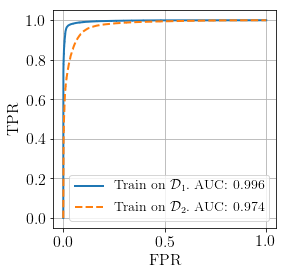

In [126]:
# Test on OS
plt.figure(figsize=(4,4));

for i in range(len(os_res)):
    auc = np.trapz(os_res[i]['fpr'], x=os_res[i]['tpr'])
    plt.plot(os_res[i]['tpr'], os_res[i]['fpr'],
             label=r'Train on $\mathcal{{D}}_{}. $ AUC: {:.3f}'.format(i+1, auc),
             linestyle=linestyles[i])
    plt.grid(True)
    plt.legend(fontsize=14)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
plt.savefig('figures/test_T1.pdf',bbox_inches='tight')

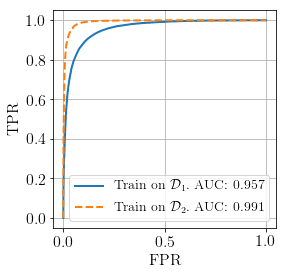

In [127]:
# Test on OK
plt.figure(figsize=(4,4));

for i in range(len(ok_res)):
    auc = np.trapz(ok_res[i]['fpr'], x=ok_res[i]['tpr'])
    plt.plot(ok_res[i]['tpr'], ok_res[i]['fpr'],
             label=r'Train on $\mathcal{{D}}_{}. $ AUC: {:.3f}'.format(i+1, auc),
             linestyle=linestyles[i])
    plt.grid(True)
    plt.legend(fontsize=14)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plt.savefig('figures/test_T2.pdf',bbox_inches='tight')

### Resnet performance varying preprocessing type

In [114]:
# building translation dictionary
runs_name = [x.split('/')[-1] for x in glob(os.path.join(runs_path, 'ResNet_*'))]
run_dict = {'_'.join(x.rsplit('_')[:-12]): x.rsplit('-')[-1] for x in runs_name}
run_dict = OrderedDict(run_dict)

# clean key list and reorder
sel_key = list(run_dict)
del sel_key[3:9]
order = [0, 2, 1, 3, 4, 8, 5, 6, 7]
sel_key = [sel_key[i] for i in order]

# remove D3
sel_key = [x for x in sel_key if 'D3' not in x]
print(sel_key)

os_res = []
ok_res = []
for k in sel_key:
    v = run_dict[k]
    os_res += [np.load(os.path.join(glob(os.path.join(results_path, '{}_TestOS'.format(v)))[0], 'result.npy')).item()]
    ok_res += [np.load(os.path.join(glob(os.path.join(results_path, '{}_TestOK'.format(v)))[0], 'result.npy')).item()]

label_list = ['$\mathbf{I}$', '$\mathbf{I}$',
             '$\mathbf{W}$', '$\mathbf{W}$',
             '$\mathbf{\Phi}$', '$\mathbf{\Phi}$',]

['ResNet_D1', 'ResNet_D2', 'ResNet_D1_transform_wv', 'ResNet_D2_transform_wv', 'ResNet_D1_transform_wv_fft_wiener2', 'ResNet_D2_transform_wv_fft_wiener2']


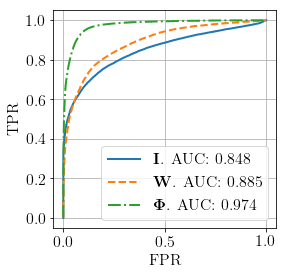

In [120]:


# Test on OS
plt.figure(figsize=(4,4));
l=0
for i in range(len(os_res)):
    #pick only train on D2
    if i % 2 == 0:
        continue
    auc = np.trapz(os_res[i]['fpr'], x=os_res[i]['tpr'])
    plt.plot(os_res[i]['tpr'], os_res[i]['fpr'],
             label='{}. AUC: {:.3f}'.format(label_list[i], auc),
             linestyle=linestyles[l])
    plt.legend()
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    l+=1

plt.savefig('figures/different_features_roc_test_T1.pdf',bbox_inches='tight')

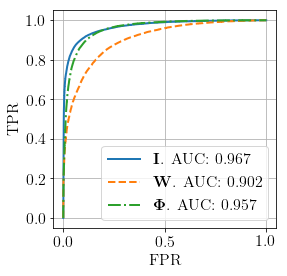

In [121]:
# Test on OK
plt.figure(figsize=(4,4));
l=0
for i in range(len(os_res)):
    #pick only train on D1
    if i % 2 != 0:
        continue
    auc = np.trapz(ok_res[i]['fpr'], x=ok_res[i]['tpr'])
    plt.plot(ok_res[i]['tpr'], ok_res[i]['fpr'],
             label='{}. AUC: {:.3f}'.format(label_list[i], auc),
             linestyle=linestyles[l])
    plt.legend()
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    l+=1
    
plt.savefig('figures/different_features_roc_test_T2.pdf',bbox_inches='tight')

### Leave one out

In [16]:
# building translation dictionary
runs_name = [x.split('/')[-1] for x in glob(os.path.join(runs_path, 'ResNet_*_no_*'))]
run_dict = {'_'.join(x.rsplit('_')[:-12]): x.rsplit('-')[-1] for x in runs_name}
run_dict = OrderedDict(run_dict)
print(run_dict)

for k, v in run_dict.items():
    no = k.rsplit('_', 4)[0].split('_', 3)[-1]
    os_res = np.load(os.path.join(glob(os.path.join(results_path, '{}_TestOS_{}'.format(v, no)))[0], 'result.npy')).item()
    ok_res = np.load(os.path.join(glob(os.path.join(results_path, '{}_TestOK_{}'.format(v, no)))[0], 'result.npy')).item()


OrderedDict([('ResNet_D3_no_D200_0_transform_wv_fft_wiener2', 'TNvVKy')])


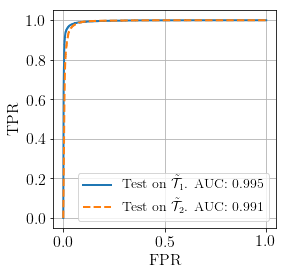

In [113]:
plt.figure(figsize=(4,4))
auc = np.trapz(os_res['fpr'], x=os_res['tpr'])
plt.plot(os_res['tpr'], os_res['fpr'],
         label=r'Test on $\tilde{{\mathcal{{T}}}}_1$. AUC: {:.3f}'.format(auc),
         linestyle=linestyles[0])
auc = np.trapz(ok_res['fpr'], x=ok_res['tpr'])
plt.plot(ok_res['tpr'], ok_res['fpr'],
         label=r'Test on $\tilde{{\mathcal{{T}}}}_2$. AUC: {:.3f}'.format(auc),
         linestyle=linestyles[1])
plt.legend(fontsize=14)
plt.grid(True)
plt.xlabel('FPR');
plt.ylabel('TPR');

plt.savefig('figures/leave_one_out_roc_train_D3.pdf',bbox_inches='tight')

### Distribution of NCC vs network output

In [29]:
# building translation dictionary
runs_name = [x.split('/')[-1] for x in glob(os.path.join(runs_path, 'ResNet_D3_transform_wv_fft_wiener2*'))]
run_dict = {'_'.join(x.rsplit('_')[:-12]): x.rsplit('-')[-1] for x in runs_name}
run_dict = OrderedDict(run_dict)
print(run_dict)

for k, v in run_dict.items():
    res = np.load(os.path.join(glob(os.path.join(results_path, '{}_*_trans'.format(v)))[0], 'result.npy')).item()

label = res['label']
pred = res['pred']
ncc_pre = res['ncc_pre']
ncc_post = res['ncc_post']

thr_ncc_pre = 0.05
ncc_post_pre = ncc_post[ncc_pre > thr_ncc_pre]
pred_pre = pred[ncc_pre > thr_ncc_pre]
label_pre = label[ncc_pre > thr_ncc_pre]

thr = 0.5
pred_anon = pred_pre[pred_pre > thr]
pred_orig = pred_pre[pred_pre <= thr]
ncc_post_anon = ncc_post_pre[pred_pre > thr]
ncc_post_orig = ncc_post_pre[pred_pre <= thr]

OrderedDict([('ResNet_D3_transform_wv_fft_wiener2', 'TXwb09')])


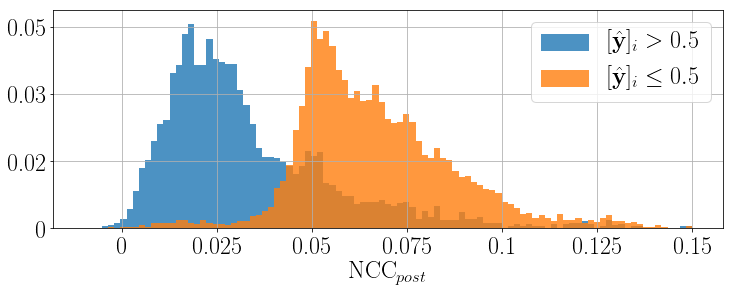

In [147]:
plt.figure(figsize=(12,4))
plt.hist(ncc_post_anon,
         density=True, 
         bins=np.linspace(-0.01, 0.15, 100),
         color=[31/255,119/255, 180/255, 0.8],
         label=r'$[\hat{{\mathbf{{y}}}}]_i > {}$'.format(thr));
plt.hist(ncc_post_orig,
         density=True, 
         bins=np.linspace(-0.01, 0.15, 100),
         color=[255/255, 127/255, 14/255, 0.8],
         label=r'$[\hat{{\mathbf{{y}}}}]_i \leq {}$'.format(thr));
plt.grid(True);
plt.legend(fontsize=24);
yticks_list = np.asarray([0, 10, 20, 30 ])
plt.yticks(yticks_list, labels=['{:.1g}'.format(x) for x in yticks_list*np.diff(np.linspace(-0.01, 0.15, 100))[0]], fontsize=24);
xticks_list = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
plt.xticks(xticks_list, labels=['{:.3g}'.format(x) for x in xticks_list], fontsize=24)
# plt.xlabel(r'$\rho$');
plt.xlabel(r'$\mathrm{NCC}_{post}$', fontsize=24);

plt.savefig('figures/hist_ncc_pred.pdf',bbox_inches='tight')

In [138]:
np.diff(np.linspace(-0.01, 0.15, 100))

array([0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161616,
       0.00161616, 0.00161616, 0.00161616, 0.00161616, 0.00161